In [74]:
import openai
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

openai.api_key = os.environ['OPENAI_API_KEY']


In [88]:
def request_gpt(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:\n"




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": extra_input + input_str}
                    ],
                temperature=1.0,
                n=3,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

def request_gpt_bin(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the 7 following bin. Sequence:\n"
    gpt_bin_message = "The trend is represented by bins \"D10+\", \"D10\", \"D8\", \"D6\", \"D4\", \"D2\", \"U2\", \"U4\", \"U6\", \"U8\", \"U10\", \"U10+\", where \"D10+\" means price dropping more than 10%, D10 means price dropping between 8% and 10%, \"D8\" means price dropping between 6% and 8%, \"U10+\" means price rising more than 10%, \"U10\" means price rising between 8% and 10%, \"D8\" means price rising between 6% and 8%, etc."




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": gpt_bin_message + extra_input + input_str}
                    ],
                temperature=1.0,
                n=3,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

In [90]:
gpt_bin_message = "The trend is represented by bins \"D10+\", \"D10\", \"D8\", \"D6\", \"D4\", \"D2\", \"U2\", \"U4\", \"U6\", \"U8\", \"U10\", \"U10+\", where \"D10+\" means price dropping more than 10%, D10 means price dropping between 8% and 10%, \"D8\" means price dropping between 6% and 8%, \"U10+\" means price rising more than 10%, \"U10\" means price rising between 8% and 10%, \"D8\" means price rising between 6% and 8%, etc."
print(gpt_bin_message)

The trend is represented by bins "D10+", "D10", "D8", "D6", "D4", "D2", "U2", "U4", "U6", "U8", "U10", "U10+", where "D10+" means price dropping more than 10%, D10 means price dropping between 8% and 10%, "D8" means price dropping between 6% and 8%, "U10+" means price rising more than 10%, "U10" means price rising between 8% and 10%, "D8" means price rising between 6% and 8%, etc.


In [85]:
def str_convert(data) :
    final_str = ""
    for elt in data :
        str_number = str(round(elt))
        final_str = final_str + str_number + ", "
    return final_str


def plot_preds_candles(df, train, test, pred, model_name, show_samples=False, savefig = ""):

    save_folder = "./plot/" + savefig
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred[0])), pred[0], label=model_name, color='purple')
    
    index_to_display = range(0, len(truth), len(truth) // 3)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()


def get_data_set(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        series = pd.Series(df['close'].values, index=df['date'])

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

    return (df_raw, train, test)

def get_data_set_return(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 1, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        df['open'] = df['open'].astype(float)
        df['return'] = ((df['close'] / df['open']) - 1) * 10000
        df = df[['date', 'return']]

        series = pd.Series(df['return'].values, index=df['date'])

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]
        df_raw['close'] = df_raw['close'].astype(float)
        df_raw['open'] = df_raw['open'].astype(float)
        df_raw['return'] = ((df_raw['close'] / df_raw['open']) - 1) * 10000
        
    return (df_raw, train, test)


def basic_seriealize(list_response) :
    dic_int_list = []
    final_dic_int_list = []
    for elt in list_response :
        sub_chains = elt.split(',')
        int_list = [int(sub_chain.strip()) for sub_chain in sub_chains]

        dic_int_list.append(int_list)

    for elt in dic_int_list :
        if (len(elt) > 7) :
            new_elt = elt[:7]
        elif (len(elt) < 7) :
            last_numb = elt[-1]
            new_elt = elt
            while (len(new_elt) < 7) :
                new_elt.append(last_numb)
        final_dic_int_list.append(new_elt)
    return final_dic_int_list


def bin_seriealize(list_response) :
    dic_int_list = []
    final_dic_int_list = []
    for elt in list_response :
        sub_chains = elt.split(',')
        for sub_chain in sub_chains :
            without_space = sub_chain.replace(" ", "")
            if (without_space == "U2") :
                dic_int_list.append(1)
            elif (without_space == "U4") :
                dic_int_list.append(3)
            elif (without_space == "U6") :
                dic_int_list.append(5)
            elif (without_space == "U8") :
                dic_int_list.append(7)
            elif (without_space == "U10") :
                dic_int_list.append(9)
            elif (without_space == "U10+") :
                dic_int_list.append(11)
            elif (without_space == "D2") :
                dic_int_list.append(-1)
            elif (without_space == "D4") :
                dic_int_list.append(-3)
            elif (without_space == "D6") :
                dic_int_list.append(-5)
            elif (without_space == "D8") :
                dic_int_list.append(-7)
            elif (without_space == "D10") :
                dic_int_list.append(-9)
            elif (without_space == "D10+") :
                dic_int_list.append(-11)
            else :
                print("error : ", without_space)
    if (len(dic_int_list) > 7) :
            dic_int_list = dic_int_list[:7]
    return dic_int_list

def convert_bin_to_close(final_dic_int_list, df_raw, input_length) :
    final_dic = []
    col_index = df_raw.columns.get_loc('close')
    row_index = input_length - 1
    close = df_raw.iloc[row_index, col_index]
    memory = close
    for elt in final_dic_int_list :
        final_dic.append(int(memory * (1 + 0.01* elt)))
        memory = final_dic[-1]
    
    return [final_dic]
        
def convert_return_to_close(final_dic_int_list, df_raw, input_length) :
    final_dic = []
    col_index = df_raw.columns.get_loc('close')
    row_index = input_length - 1
    open = df_raw.iloc[row_index, col_index]
    memory = open
    for elt in final_dic_int_list[0] :
        final_dic.append(int((elt/10000 + 1) * memory))
        memory = final_dic[-1]
        
    return [final_dic]

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34796']
[[34796, 34796, 34796, 34796, 34796, 34796, 34796]]


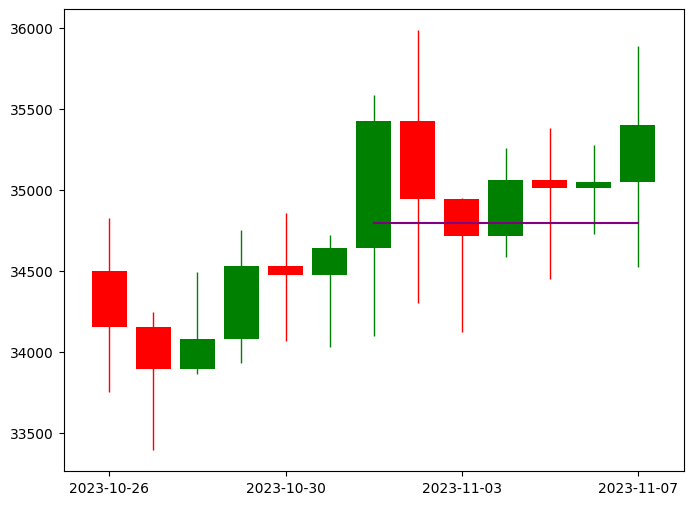

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34735, 34784, 34944']
[[34735, 34784, 34944, 34944, 34944, 34944, 34944]]


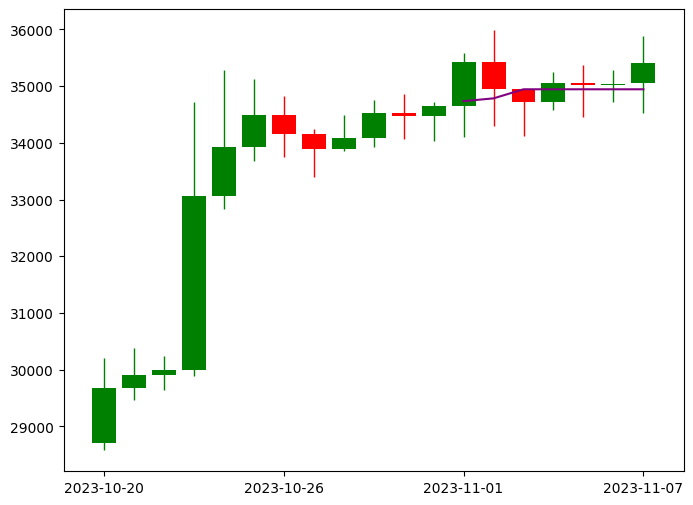

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34983, 36856, 36849, 36921, 37014, 36997, 37354, 37721, 37649, 38106, 38229, 38151, 38430, 38501']
[[34983, 36856, 36849, 36921, 37014, 36997, 37354]]


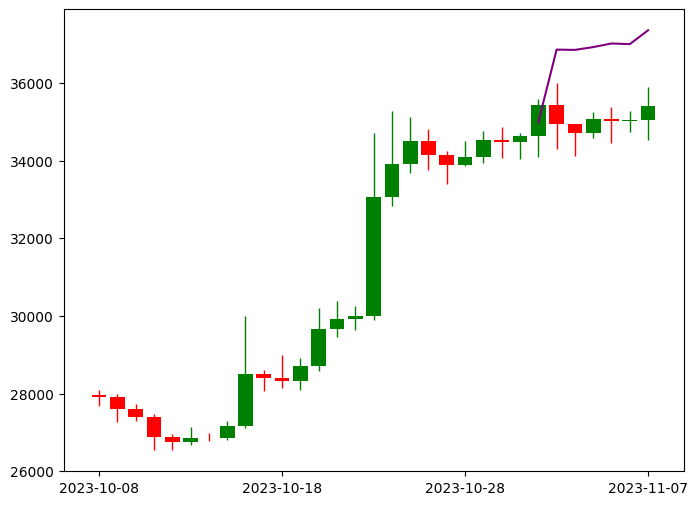

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34605, 35050, 35460, 35611, 35893, 35900, 35791, 35027, 34791, 34742, 34299, 34075']
[[34605, 35050, 35460, 35611, 35893, 35900, 35791]]


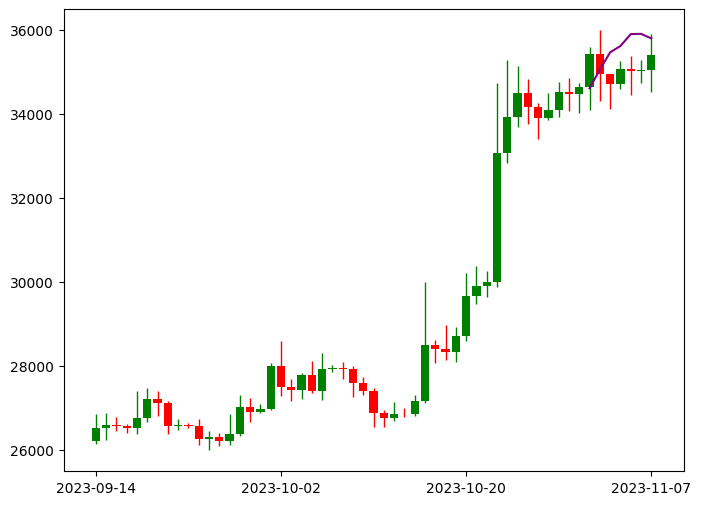

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34681']
[[34681, 34681, 34681, 34681, 34681, 34681, 34681]]


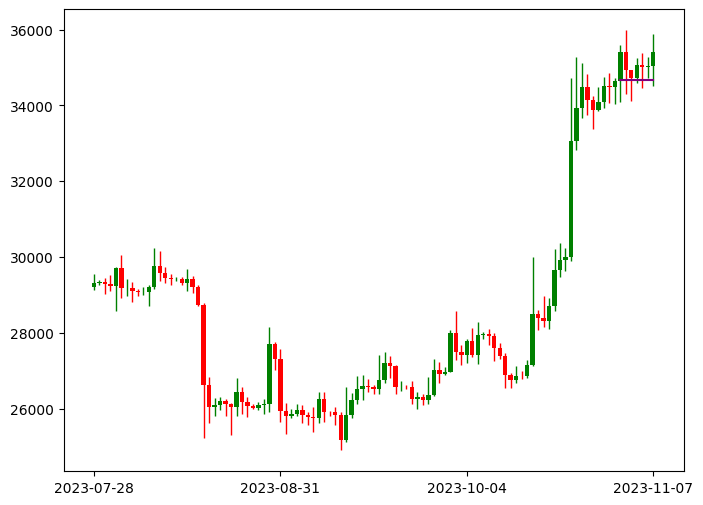

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

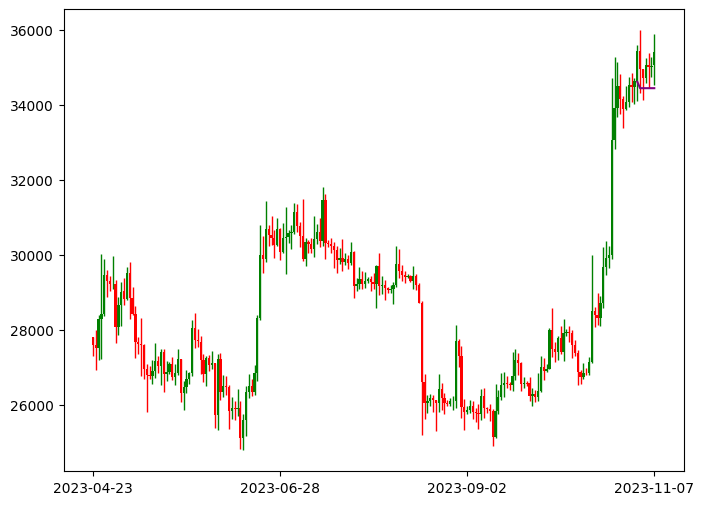

In [78]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "naive/"


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = basic_seriealize(list_response)

    print(final_dic_int_list)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic_int_list, "gpt-4-vision-preview", show_samples=False, savefig = current_folder)




Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['92, -169, 143']
int list return
[[92, -169, 143, 143, 143, 143, 143]]
int list, close
[[34959, 34368, 34859, 35357, 35862, 36374, 36894]]


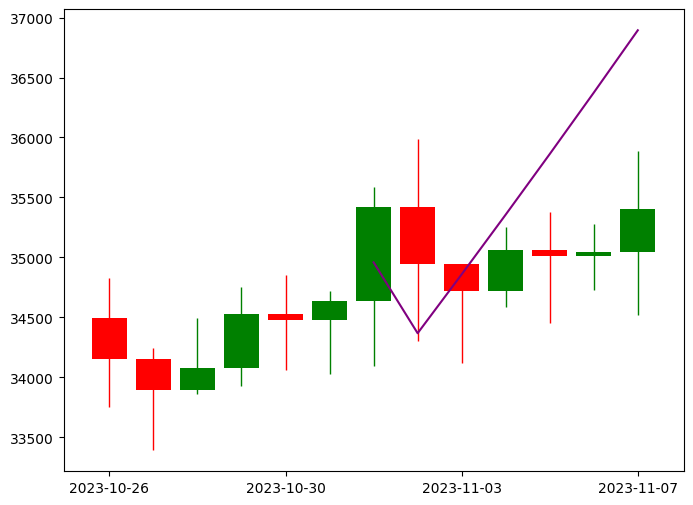

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['78, 29, 37']
int list return
[[78, 29, 37, 37, 37, 37, 37]]
int list, close
[[34910, 35011, 35140, 35270, 35400, 35530, 35661]]


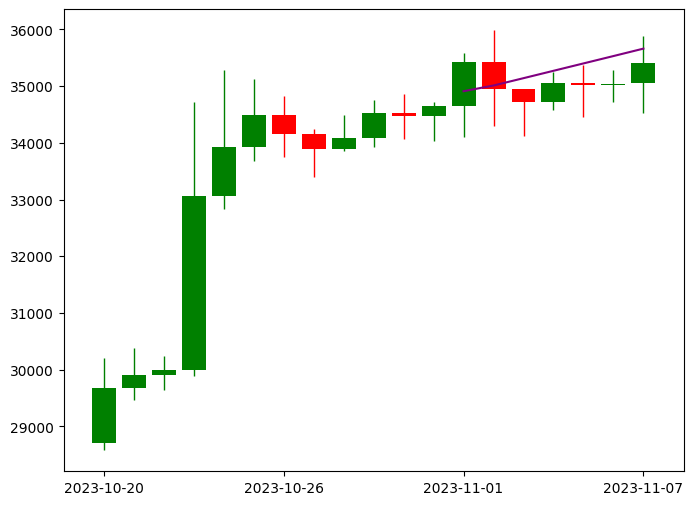

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['657, 220, 184']
int list return
[[657, 220, 184, 184, 184, 184, 184]]
int list, close
[[36916, 37728, 38422, 39128, 39847, 40580, 41326]]


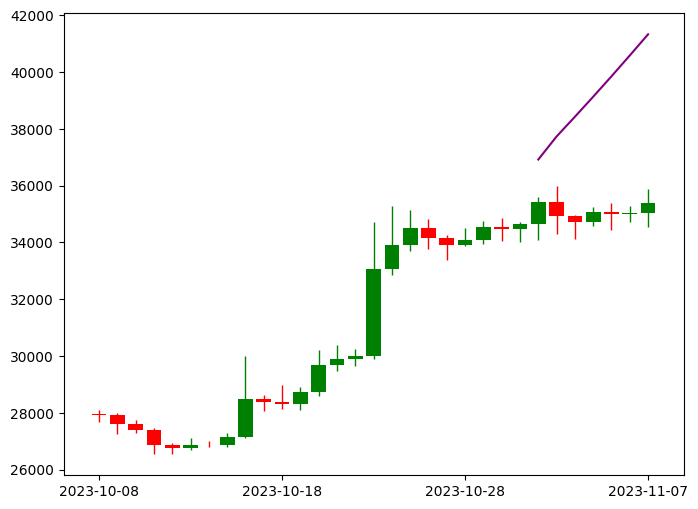

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ["I'm sorry, but I am unable to continue the sequence as it doesn't follow a clear pattern that can be logically deduced or mathematically computed. If you happen to have additional information regarding the sequence or its rule of formation, I'd be glad to assist you further."]
Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56,

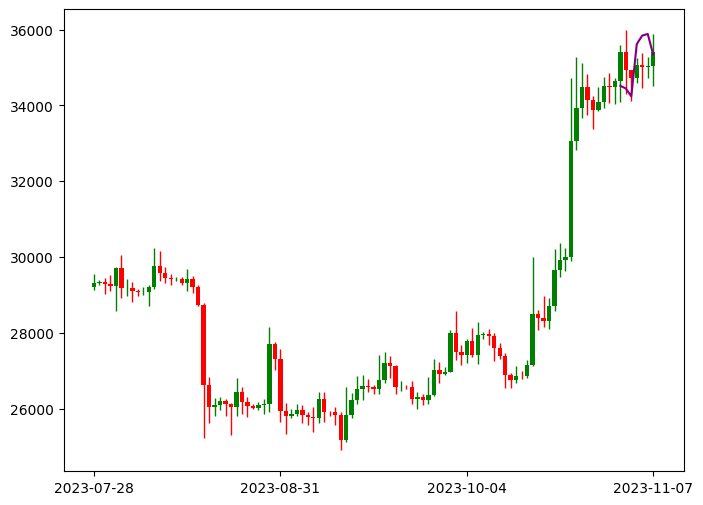

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-252']
int list return
[[-252, -252, -2

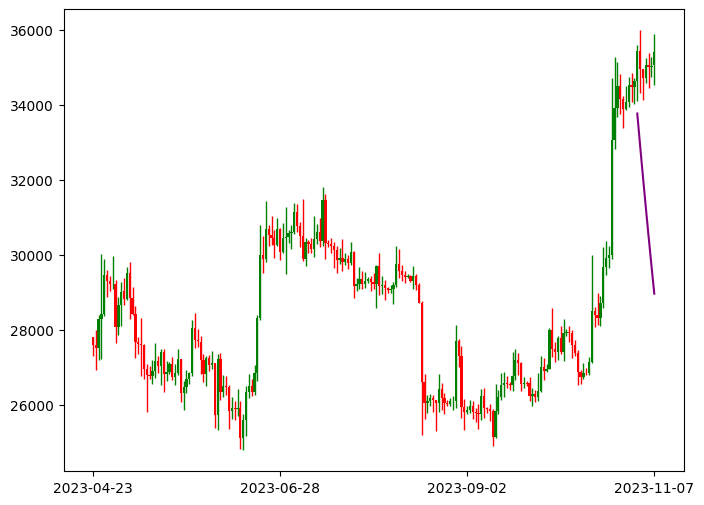

In [79]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "return/"


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set_return("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    try :
        final_dic_int_list = basic_seriealize(list_response)
    except :
        continue
    print("int list return")
    print(final_dic_int_list)
    
    final_dic = convert_return_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False,  savefig = current_folder)

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, D2, U2, U4, D2', 'U2, U2, U4, U4, U4, U2, U2', 'D2, U2, U6, U2, D2, U4,']
error :  
serialized :  [-1, 1, 3, -1, 1, 3, -1]
int list, close
[[34294, 34636, 35675, 35318, 35671, 36741, 36373]]


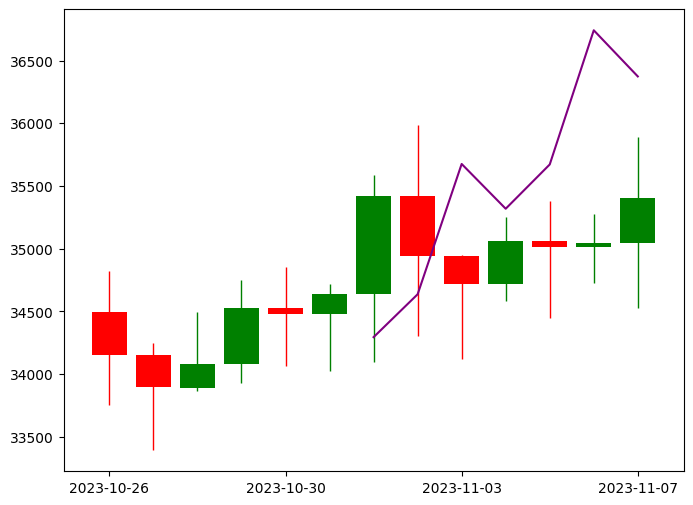

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, D4, D2, D6, D8, D10', 'U2, U2, D2, D4, D6, D6, D8', 'D2, U2, D4, D6, U2, U4, D2']
serialized :  [-1, 1, -3, -1, -5, -7, -9]
int list, close
[[34294, 34636, 33596, 33260, 31597, 29385, 26740]]


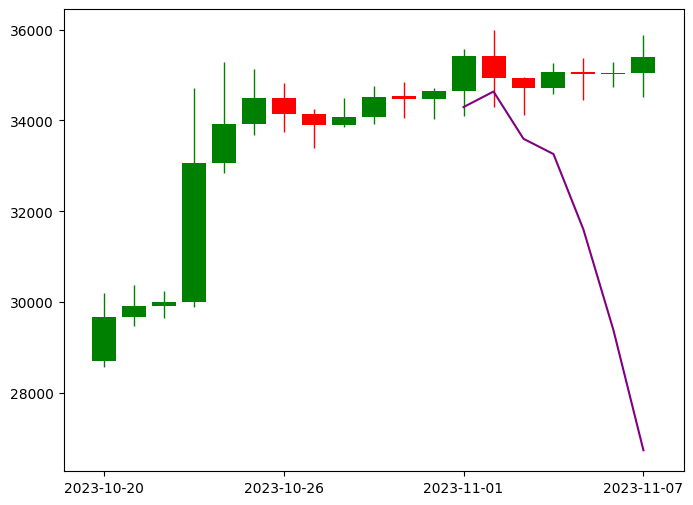

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U4, U2, D2, D4, D2, D6', 'D2, U2, U2, U4, U4, U6, U6', 'U2, U4, D2, D4, D6, U2, U4']
serialized :  [1, 3, 1, -1, -3, -1, -5]
int list, close
[[34987, 36036, 36396, 36032, 34951, 34601, 32870]]


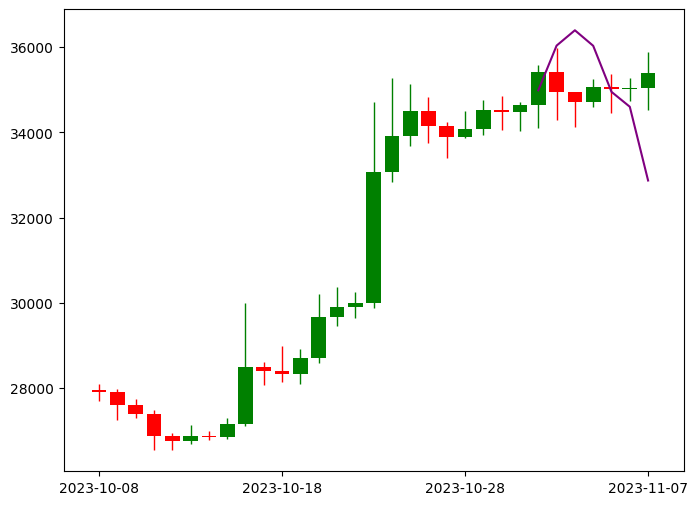

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U4, U6, U8, U10, U10+, D10+', 'D2, U2, U2, U4, U6, U10, U10+', 'U2, U2, D2, D4, D6, D8, D10']
serialized :  [1, 3, 5, 7, 9, 11, -11]
int list, close
[[34987, 36036, 37837, 40485, 44128, 48982, 43593]]


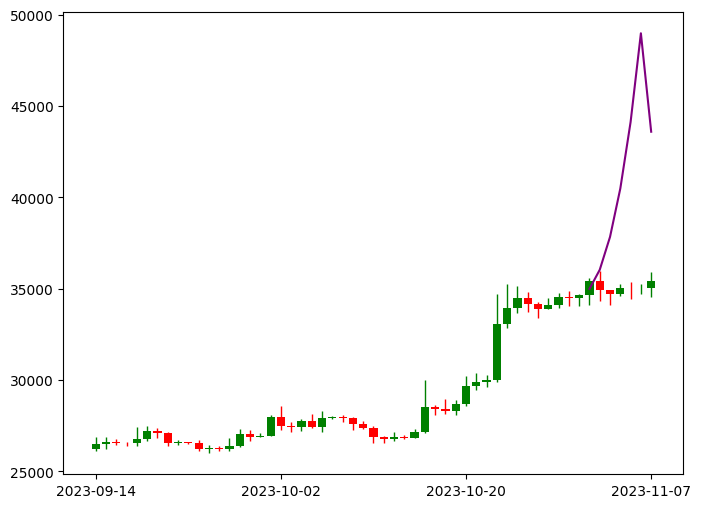

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, D2, D4, D4, D6, D6', 'D2, D4, D6, D8, D10, D10+, U2', 'D6, D4, D2, U2, U4, U6, U8']
serialized :  [1, 1, -1, -3, -3, -5, -5]
int list, close
[[34987, 35336, 34982, 33932, 32914, 31268, 29704]]


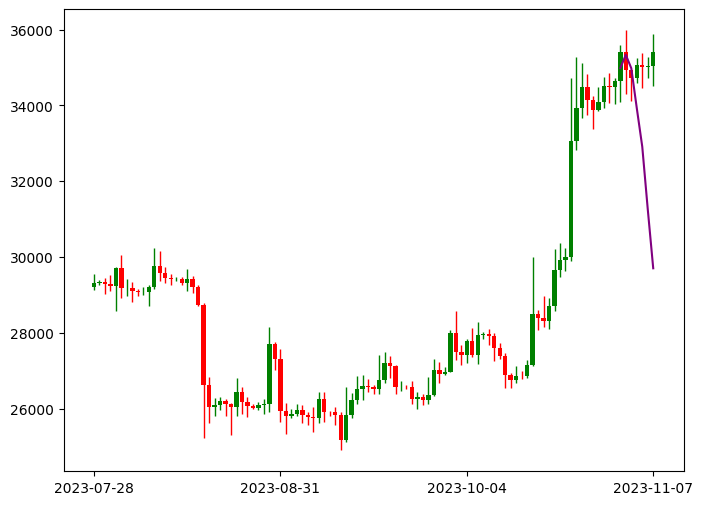

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

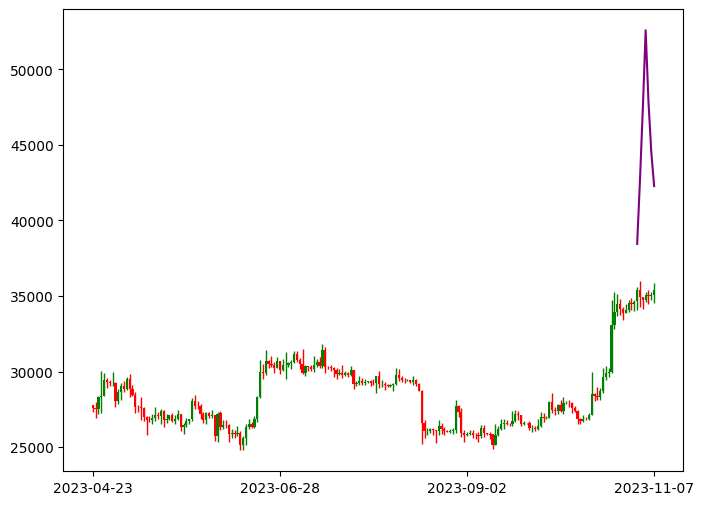

In [86]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "bin/"

for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt_bin(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = bin_seriealize(list_response)
    print("serialized : ", final_dic_int_list)

    final_dic = convert_bin_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False, savefig= current_folder )


